In [34]:
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import random
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
from pycococreatortools import pycococreatortools
from IPython import embed
from tqdm import tqdm
from IPython.core.display import display, HTML
import os
import shutil
import glob 
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode

# labels = ['chair', 'cushion', 'door', 'indoor-plant', 'table', 'vase']
# labels= ['chair', 'cushion', 'door', 'lamp', 'sofa', 'table']
# ['chair', 'door', 'table', 'indoor-plant', 'cushion', 'sofa'] != ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']

labels = ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
# labels = ['chair', 'door', 'table', 'indoor-plant', 'cushion', 'sofa']

semantic_json_root = '/checkpoint/apratik/ActiveVision/active_vision/info_semantic'

class CocoCreator:
    # Assumes root_data_dir has both te GT and propagated segmentation labels
    def __init__(self, root_data_dir, semantic_json_root, labels, segm_dir):
        self.rdd = root_data_dir
        self.sjr = semantic_json_root
        self.labels = labels
        self.segm_dir = segm_dir
        sorted(self.labels)
#         print(f"Init CocoCreator for labels {self.labels}")
        
    def create_coco(self, scene, coco_file_name, pct, segmids, traj):
        hsd = self.load_semantic_json(scene)
        self.create_metadata(hsd)
        self.create_annos(hsd, scene, pct, segmids, traj)
        self.save_json(coco_file_name)
        self.save_visual_dataset(coco_file_name, scene)
    
    def save_visual_dataset(self, coco_file_name, scene):
        DatasetCatalog.clear()
        MetadataCatalog.clear()

        register_coco_instances('foobar', {}, coco_file_name, os.path.join(self.rdd, 'rgb'))
        MetadataCatalog.get('foobar')
        dataset_dicts = DatasetCatalog.get('foobar')
        
        save_dir = os.path.join(self.segm_dir, 'coco_visuals')
        print(f'save_dir {save_dir}')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        for d in dataset_dicts:
            img = cv2.imread(d["file_name"])
            x = d['file_name'].split('/')[-1]
#             print(f"filename {d['file_name'], x}, visual_file {os.path.join(save_dir, x)}")
            visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get('foobar'), scale=0.5)
            vis = visualizer.draw_dataset_dict(d)
            img = vis.get_image()
            cv2.imwrite(os.path.join(save_dir, x), img)
#             plt.figure(figsize=(12 , 8))
#             plt.imshow(img)
#             plt.show()
        
    def save_json(self, coco_file_name):
        coco_output = {
            "info": self.INFO,
            "licenses": self.LICENSES,
            "categories": self.CATEGORIES,
            "images": self.IMAGES,
            "annotations": self.ANNOTATIONS,
        }
        
        print(f"Dumping {len(coco_output['annotations'])} annotations to {coco_file_name}")
        with open(coco_file_name, "w") as output_json:
            json.dump(coco_output, output_json)
    
    def create_annos(self, hsd, scene, pct, segmids, traj):
        coco_img_id = -1
        count = 0
        segm_dir = self.segm_dir
        print(f"Scene {scene}, seg dir {segm_dir}")       
        img_dir = os.path.join(self.rdd, 'rgb')
        fs = self.get_segm_ids(segmids, traj)
#         fs = self.get_segm_files(segm_dir, pct)
        print(f"Creating COCO annotations for {len(fs)} images \n img_dir {img_dir}")
        
        for f in tqdm(fs):
            image_id = int(f.split('.')[0])
            try:
                prop_path = os.path.join(segm_dir, "{:05d}.npy".format(image_id))
                annot = np.load(prop_path).astype(np.uint32)
            except Exception as e:
                print(e)
                continue


            img_filename = "{:05d}.jpg".format(image_id)            
            img = Image.open(os.path.join(img_dir, img_filename))

            # COCO ID and names
            coco_img_id += 1

            image_info = pycococreatortools.create_image_info(
                coco_img_id, os.path.basename(img_filename), img.size
            )

            self.IMAGES.append(image_info)
        
            # for each annotation add to coco format
            for i in np.sort(np.unique(annot.reshape(-1), axis=0)):
                try:
                    if hsd["id_to_label"][i] < 1 or self.label_id_dict[hsd["id_to_label"][i]] not in labels:# or hsd["id_to_label"][i] not in self.label_id_dict:
                        continue
                    category_info = {"id": self.new_old_id[hsd["id_to_label"][i]], "is_crowd": False}
#                     print(f'category_info {category_info}')
                except:
                    continue

                binary_mask = (annot == i).astype(np.uint32)

                annotation_info = pycococreatortools.create_annotation_info(
                    count, coco_img_id, category_info, binary_mask, img.size, tolerance=2
                )
                if annotation_info is not None:
                    self.ANNOTATIONS.append(annotation_info)
                    count += 1
        
    def create_metadata(self, hsd):
        self.INFO = {}
        self.LICENSES = [{}]
        self.CATEGORIES = []
        self.IMAGES = []
        self.ANNOTATIONS = []
        
        self.label_id_dict = {}
        self.new_old_id = {}
        idc = 1
        for obj_cls in hsd["classes"]:
            if obj_cls["name"] in self.labels:
                self.CATEGORIES.append({"id": idc, "name": obj_cls["name"], "supercategory": "shape"})
                self.label_id_dict[obj_cls["id"]] = obj_cls["name"]
                self.new_old_id[obj_cls['id']] = idc
                idc += 1
        
    def load_semantic_json(self, scene):
        replica_root = '/datasets01/replica/061819/18_scenes'
        habitat_semantic_json = os.path.join(replica_root, scene, 'habitat', 'info_semantic.json')
#         habitat_semantic_json = os.path.join(self.sjr, scene + '_info_semantic.json')
#         print(f"Using habitat semantic json {habitat_semantic_json}")
        with open(habitat_semantic_json, "r") as f:
            hsd = json.load(f)
        if hsd is None:
            print("Semantic json not found!")
        return hsd
    
    def get_segm_ids(self, ids, traj):
        fs = []
        cs = [os.path.basename(x) for x in glob.glob(os.path.join(f'/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/{traj}/default/seg', '*.npy'))]
#         print(cs[:3])
        for x in ids:
            f = "{:05d}.npy".format(x)
            if f in cs:
                fs.append(f)
        return fs
        
    def get_segm_files(self, segm_dir, pct):
        cs = [os.path.basename(x) for x in glob.glob(os.path.join(segm_dir, '*.npy'))]
        cs.sort()
        frq = 1/pct
        fs = []
        for x in range(0, len(cs), int(frq)):
            fs.append(cs[x])
        return fs 

def run_coco(out_dir, img_dir,pct, coco_name, segmids, traj):
    cbase = CocoCreator(img_dir, semantic_json_root, labels, out_dir)
    cbase.create_coco(
        scene='apartment_0', 
        coco_file_name=os.path.join(out_dir, coco_name),
        pct=pct,
        segmids=segmids,
        traj=traj,
    )

In [79]:
# start with job dir 
#     * for each trajectory’s GT setting (5,10,15,20), create a validation set as above
#     * for each propagation length, create a training set as above

import os
import cv2
import json
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
import glob
from pycocotools.coco import COCO

# job_dir = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/20-10-2021/23:04:37'
job_dir = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/04-11-2021/14:30:11'
data_dir =  '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/'

gt=5

def get_validation_set(ids, p):
    val = []
    for x in ids:
        val.append([x-p, x+p])
    val = [item for sublist in val for item in sublist]

#     print(len(val), val)
    return val
        
def get_training_set(ids, p, val):
    tr = []
    val_idx = 0
    for x in ids:
        for _ in range(p):
            tr.append(val[val_idx])
        tr.append(x)
        val_idx+=1
        for _ in range(p):
            tr.append(val[val_idx])
        val_idx+=1
    return tr

def get_training_set_actual(f, img_dir):
    annotation_file = os.path.join(f, 'coco_train.json')

    # Load COCO annotations
    coco = COCO(annotation_file)
    return [int(x['file_name'].split('.')[0]) for x in coco.dataset["images"]]
#     print(coco.getImgIds())

def validate(val, train, gt, p):
    print(f'train {len(train)}, expectd {(2*p+1)*gt}')
    assert len(train) >= (2*p+1)*gt -1
    
def visualize_coco(coco_file_name, img_dir):
    DatasetCatalog.clear()
    MetadataCatalog.clear()

    register_coco_instances('foobar', {}, coco_file_name, os.path.join(img_dir, 'rgb'))
    MetadataCatalog.get('foobar')
    dataset_dicts = DatasetCatalog.get('foobar')
    
    print(coco_file_name, len(dataset_dicts))
    fig, axs = plt.subplots(int(len(dataset_dicts)), figsize=(20,20))
    ctr = 0
    
    for y in range(int(len(dataset_dicts))):
#         for y in range(5):
        d = dataset_dicts[ctr]
        ctr += 1
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get('foobar'), scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        img = vis.get_image()
        axs[y].set_axis_off()
        axs[y].imshow(img)
        axs[y].set_title(d['file_name'].split('/')[-1])
#         else:
#             axs[x, y].set_axis_off()
#             axs[x, y].imshow(img)
#             axs[x, y].set_title(d['file_name'].split('/')[-1])
    plt.show()

# for traj in range(1, 2):
traj = 1
out_dir = f'/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/{traj}/default/seg'
img_dir = f'/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/{traj}/default'
make_zero = True
p = 4
#     for p in range(0,10,2):

f = os.path.join(job_dir, str(traj), 'default', f'pred_label_gt{gt}p{p}')
print(f)

/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/04-11-2021/14:30:11/1/default/pred_label_gt5p4


In [76]:
if not os.path.isfile(os.path.join(f, 'coco_train.json')):
    print(f'no coco_train.json for {f}, skipping ... ')
#     continue

train_ids = os.path.join(f, 'train_img_id.json')
if os.path.isfile(train_ids):
    with open(train_ids, "r") as x:
        data = json.load(x)
        
print(data)

{'img_id': [294, 502, 894, 1212, 1492], 'propagation_step': 4}


In [80]:
#                 print(traj, data)
val = get_validation_set(data['img_id'], p)

train = get_training_set_actual(f, img_dir)
print(f"p {p} gt ids {data['img_id']}\nval {val}\ntrain {train}")

validate(val, train, gt, p)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
p 4 gt ids [294, 502, 894, 1212, 1492]
val [290, 298, 498, 506, 890, 898, 1208, 1216, 1488, 1496]
train [290, 291, 292, 293, 294, 295, 296, 297, 298, 498, 499, 500, 501, 502, 503, 504, 505, 506, 890, 891, 892, 893, 894, 895, 896, 897, 898, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496]
train 45, expectd 45


  0%|          | 0/5 [00:00<?, ?it/s]

Scene apartment_0, seg dir /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg
Creating COCO annotations for 5 images 
 img_dir /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/rgb


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Dumping 30 annotations to /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg/coco_gt5_0train.json
30 30
save_dir /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg/coco_visuals
30 30
/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg/coco_gt5_0train.json 5


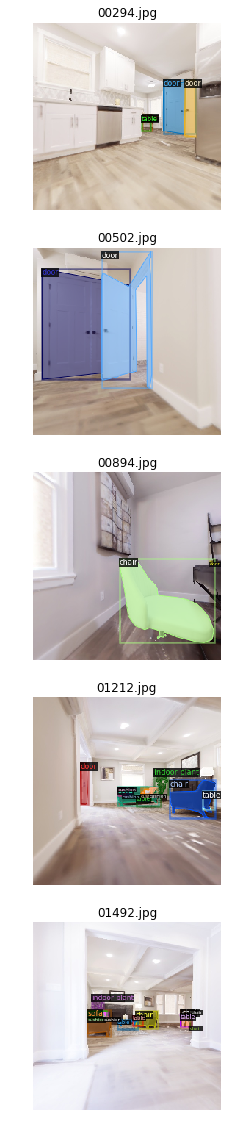

In [66]:
# create coco from val set
make_zero = True
if make_zero:
    run_coco(out_dir, img_dir, 1, f'coco_gt{gt}_0train.json', data['img_id'], traj)
    visualize_coco(os.path.join(out_dir, f'coco_gt{gt}_0train.json'), img_dir)
    make_zero = False
#     continue

Scene apartment_0, seg dir /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg


 10%|█         | 1/10 [00:00<00:01,  6.49it/s]

Creating COCO annotations for 10 images 
 img_dir /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/rgb


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


Dumping 62 annotations to /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg/coco_gt5_4leakyval.json
62 62
save_dir /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg/coco_visuals
62 62
/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg/coco_gt5_4leakyval.json 10


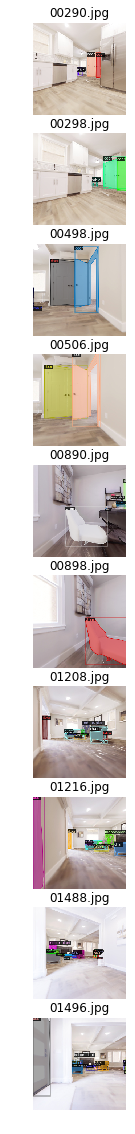

In [81]:
# p0_train = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg/coco_gt5_0train.json'
# p4_train = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/04-11-2021/14:30:11/1/default/pred_label_gt5p4/coco_train.json'
# pr_val = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg/coco_gt5_4val.json'

run_coco(out_dir, img_dir, 1, f'coco_gt{gt}_{p}leakyval.json', val, traj)

visualize_coco(os.path.join(out_dir, f'coco_gt{gt}_{p}leakyval.json'), img_dir)
#         visualize_coco(os.path.join(out_dir, f'coco_gt{gt}p{p}_train.json'), img_dir)
        # call training 

In [69]:
# visualize_coco(os.path.join(f, f'coco_train.json'), img_dir)
print(os.path.join(f, f'coco_train.json'))

/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/04-11-2021/14:30:11/1/default/pred_label_gt5p4/coco_train.json
